In [1]:
import numpy as np
import pandas as pd
import json
import re
from bert_score import score as bert_score_fn
from bleurt import score as bleurt_score_module

d:\Research_Assistant\evaluation_radiology_gpt\test-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../cleaning_before_eval/ready_to_eval.csv')
df.head()

,No,Question,Dr Answer,Claude Answer,Qwen Answer,GPT Answer,Deepseek RAG Answer,Deepseek non RAG Answer,Claude Full Answer,Qwen Full Answer,GPT Full Answer,Deepseek RAG Full Answer,Deepseek non RAG Full Answer
0,1.0,Pasien mengalami demam pada waktu malam. Sebel...,"Demam Tifoid 70%, Demam Berdarah Dengue 30%","Demam Tifoid, Leptospirosis, Demam Berdarah De...","Demam Biasa, Dispepsia, Asma, Infeksi Saluran ...","Demam Biasa, Demam Tifoid, Demam Berdarah Deng...","Demam Tifoid (Typhoid Fever), Malaria, Leptosp...","Malaria, Infeksi Saluran Kemih (ISK) atau Piel...","Berdasarkan gejala yang disampaikan, saya akan...","Berdasarkan gejala yang disampaikan, yaitu dem...","Berdasarkan gejala yang disampaikan, yaitu dem...","Berdasarkan gejala yang dialami pasien, yaitu ...",Berdasarkan gejala yang Anda sebutkan—demam pa...
1,2.0,Pasien mengalami buang air besar cair lebih da...,"Gastroenteritis (GE) Akut 70%, Intoleransi Lak...","Gastroenteritis (GE) Akut, Disentri, Infeksi E...","Diare Akut, Gastroenteritis, Dispepsia, Infeks...","Gastroenteritis Akut, Infeksi Escherichia coli...","Gastroenteritis Akut, Keracunan Makanan, Infek...","Gastroenteritis Akut, Keracunan Makanan, Koler...","Berdasarkan informasi klinis yang diberikan, s...","Berdasarkan gejala yang disampaikan, yaitu bua...","Berdasarkan informasi yang diberikan, pasien m...","Berdasarkan informasi yang diberikan, pasien m...",Berdasarkan gejala yang Anda deskripsikan—diar...
2,3.0,Pasien datang dengan keluhan demam selama 6 ha...,DBD 80%,"Demam Tifoid, Malaria, DBD, Leptospirosis, Inf...","Demam Biasa, Dispepsia, Asma, Demam Dengue, Lu...","Demam Berdarah Dengue, Demam Tifoid, Malaria, ...","Demam Berdarah Dengue (DBD), Demam Tifoid, Lep...","Demam Berdarah Dengue (DBD) / Dengue Fever, Ch...","Berdasarkan informasi yang diberikan, saya aka...","Berdasarkan gejala yang disampaikan, yaitu dem...",Berdasarkan keluhan yang disampaikan oleh pasi...,Berdasarkan keluhan pasien yang meliputi demam...,Berdasarkan gejala yang Anda sebutkan—demam ≥6...
3,4.0,Pasien menderita demam disertai munculnya brun...,"Infeksi Bakteri/Virus (Sistemik) 50%, Infeksi ...","DBD, Infeksi Bakteri/Virus (Sistemik), Infeksi...","Demam Biasa, Dispepsia, Asma, Infeksi Lokal, A...","Infeksi Kulit (Dermatitis atau Selulitis), Kej...","Infeksi Bakteri (Selulitis), Reaksi Alergi (De...",Erisipelas (Infeksi Bakteri pada Kulit dan Jar...,"Berdasarkan informasi klinis yang diberikan, s...","Berdasarkan gejala yang disampaikan, yaitu dem...","Berdasarkan informasi yang diberikan, pasien m...",### Analisis Gejala dan Kemungkinan Diagnosis\...,Berdasarkan gejala dan temuan pemeriksaan yang...
4,5.0,Pasien nyeri dada sejak 4 jam lalu seperti ter...,"Angina Pekrotis 80%, Infark Miokard Akut (Sera...","Angina Pekrotis, Infark Miokard Akut (Serangan...","Infark Miokard Akut (Serangan Jantung), Dispep...","Angina Pekrotis, Infark Miokard, Penyakit Musk...","Angina Pectoris (Kardiovaskular), Infark Mioka...","Infark Miokard Akut (Serangan Jantung), Angina...",Berdasarkan informasi yang diberikan dalam kon...,"Berdasarkan gejala yang disampaikan, yaitu nye...","Berdasarkan informasi yang diberikan, pasien m...",### Analisis Gejala\r\n\r\nPasien mengeluhkan ...,Berdasarkan gejala nyeri dada seperti terhimpi...


In [3]:
answer_lists = {}
answer_columns = [col for col in df.columns if col.endswith(' Answer')]

for col_name in answer_columns:
    if (col_name.endswith(' Full Answer')): continue
    model = col_name.removesuffix(' Answer')
    answers = df[col_name].tolist()
    answer_lists[model] = answers

In [4]:
answer_lists

{'Dr': ['Demam Tifoid 70%, Demam Berdarah Dengue 30%',
  'Gastroenteritis (GE) Akut 70%, Intoleransi Laktosa 30%',
  'DBD 80%',
  'Infeksi Bakteri/Virus (Sistemik) 50%, Infeksi Jaringan Lunak (Selulitis) 70%',
  'Angina Pekrotis 80%, Infark Miokard Akut (Serangan Jantung) 80%',
  'Asma 100%, Bronkitis Akut 70%, Penyakit Paru Obstruktif Kronik 50%',
  'Bronkitis Akut 100%',
  'Bronkitis Akut 80%, Asma Bronkial 50%',
  'Dispepsia 100%, Pneumonia 50%, Infeksi Saluran Pernapasan 50%',
  'Dispepsia 80%, refluk Gastroesofagus (GERD) 90%',
  'Gastroenteritis Akut 70%, Infeksi saluran pencernaan 50%',
  'Batu Ginjal 70%, Kolik Renal 80%, Ganguan Saluran kemih 100%, Ureterolitiasis 70%',
  'Peritonitis 50%, Infeksi Saluran Pencernaan Akut 70%, Obstruksi Usus 70%',
  'Kolesistitis Akut 70%, Dispepsia 70%',
  'Appendisitis Akut 70%, Kolika Abdominalis 80%',
  'Dispepsia 80%, Infeksi Saluran Pernapasan Atas 80%',
  'Infeksi Saluran pernapasan atas 70%, Influenza 80%',
  'Infeksi Saluran Pernapasan

In [5]:
with open('kamus.json', 'r') as file:
    SYNONYM_MAP = json.load(file)
    
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\b\d+(\.\d+)?\s*%', '', text)
    text = re.sub(r'\b\d+(\.\d+)?\b', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    for abbr, canonical in SYNONYM_MAP.items():
        abb = abbr.lower()
        canon = canonical.lower()

        if (text == canon): break
        pattern = rf'\b{re.escape(abb)}\b'
        if re.search(pattern, text):
            text = re.sub(pattern, canon, text)
            break
        
    return text

In [6]:
for name, ans_list in answer_lists.items():
    new_list = []
    for ans in ans_list:
        a_list = ans.split(',')
        a_list = [normalize_text(a) for a in a_list]
        new_list.append(', '.join(a_list))
    answer_lists[name] = new_list

answer_lists

{'Dr': ['demam tifoid, demam berdarah dengue',
  'gastroenteritis gastroenteritis, intoleransi laktosa',
  'demam berdarah dengue',
  'infeksi bakterivirus sistemik, infeksi jaringan lunak sellulitis',
  'angina pectoris pekrotis, serangan jantung serangan jantung',
  'asma, bronkitis, penyakit paru obstruktif kronik',
  'bronkitis',
  'bronkitis, asma',
  'dyspepsia, pneumonia, ispa',
  'dyspepsia, refluk gastroesofagus gastroesophageal reflux disease',
  'gastroenteritis, infeksi saluran nafas pencernaan',
  'batu ginjal, kolik renal, ganguan saluran kemih, ureterolitiasis',
  'peritonitis, infeksi saluran nafas pencernaan akut, obstruksi usus',
  'kolesistitis akut, dyspepsia',
  'appendisitis, kolika abdominalis',
  'dyspepsia, ispa atas',
  'ispa atas, influenza',
  'ispa atas, bronkitis',
  'influenza, ispa atas',
  'ispa',
  'demam berdarah dengue, demam berdarah dengue, demam umuminfeksi virus',
  'demam berdarah dengue',
  'awal infeksi virus',
  'hipertensi stage, post syncop

In [7]:
eval_df = df[['No', 'Question']]
checkpoint = "../bleurt/bleurt/test_checkpoint"
scorer = bleurt_score_module.BleurtScorer(checkpoint)

for k, v in answer_lists.items():
    if k == 'Dr': continue

    print(f'k={k}')
    # BERT Score
    P, R, F1 = bert_score_fn(refs=answer_lists['Dr'], cands=answer_lists[k], lang='en', verbose=True)
    eval_df[f'{k}_P'] = P.tolist()
    eval_df[f'{k}_R'] = R.tolist()
    eval_df[f'{k}_F1'] = F1.tolist()

    # BLEURT Score
    scores = scorer.score(references=answer_lists['Dr'], candidates=answer_lists[k])
    eval_df[f'{k}_BLEURT'] = scores



INFO:tensorflow:Reading checkpoint ../bleurt/bleurt/test_checkpoint.
INFO:tensorflow:Config file found, reading.
INFO:tensorflow:Will load checkpoint dbleurt_tiny
INFO:tensorflow:Loads full paths and checks that files exists.
INFO:tensorflow:... name:dbleurt_tiny
INFO:tensorflow:... vocab_file:vocab.txt
INFO:tensorflow:... bert_config_file:bert_config.json
INFO:tensorflow:... do_lower_case:True
INFO:tensorflow:... max_seq_length:512
INFO:tensorflow:Creating BLEURT scorer.
INFO:tensorflow:Creating WordPiece tokenizer.

INFO:tensorflow:WordPiece tokenizer instantiated.
INFO:tensorflow:Creating Eager Mode predictor.
INFO:tensorflow:Loading model.
INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:BLEURT initialized.


k=Claude


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 2/2 [00:10<00:00,  5.40s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 35.24it/s]


done in 10.84 seconds, 4.15 sentences/sec


C:\Users\Asus\AppData\Local\Temp\ipykernel_24260\1208546096.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df[f'{k}_P'] = P.tolist()
C:\Users\Asus\AppData\Local\Temp\ipykernel_24260\1208546096.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df[f'{k}_R'] = R.tolist()
C:\Users\Asus\AppData\Local\Temp\ipykernel_24260\1208546096.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

k=Qwen


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 2/2 [00:09<00:00,  4.72s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 83.33it/s]
C:\Users\Asus\AppData\Local\Temp\ipykernel_24260\1208546096.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df[f'{k}_P'] = P.tolist()
C:\Users\Asus\AppData\Local\Temp\ipykernel_24260\1208546096.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df[f'{k}_R'] = R.tolist()
C:\Users\Asus\AppData\Local\Temp\ipykernel_24260\1208546096.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

done in 9.45 seconds, 4.76 sentences/sec


C:\Users\Asus\AppData\Local\Temp\ipykernel_24260\1208546096.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df[f'{k}_BLEURT'] = scores


k=GPT


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 2/2 [00:07<00:00,  3.83s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 99.50it/s]
C:\Users\Asus\AppData\Local\Temp\ipykernel_24260\1208546096.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df[f'{k}_P'] = P.tolist()
C:\Users\Asus\AppData\Local\Temp\ipykernel_24260\1208546096.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df[f'{k}_R'] = R.tolist()


done in 7.67 seconds, 5.87 sentences/sec
k=Deepseek RAG


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 2/2 [00:13<00:00,  6.82s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 60.77it/s]


done in 13.65 seconds, 3.30 sentences/sec
k=Deepseek non RAG


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 2/2 [00:13<00:00,  6.84s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 78.90it/s]


done in 13.70 seconds, 3.28 sentences/sec


In [8]:
eval_df.describe()

,No,Claude_P,Claude_R,Claude_F1,Claude_BLEURT,Qwen_P,Qwen_R,Qwen_F1,Qwen_BLEURT,GPT_P,...,GPT_F1,GPT_BLEURT,Deepseek RAG_P,Deepseek RAG_R,Deepseek RAG_F1,Deepseek RAG_BLEURT,Deepseek non RAG_P,Deepseek non RAG_R,Deepseek non RAG_F1,Deepseek non RAG_BLEURT
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,...,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,23.000000,0.860099,0.937190,0.896687,0.085873,0.814206,0.849872,0.830785,-0.547667,0.820598,...,0.845941,-0.290985,0.811874,0.875391,0.842011,-0.403036,0.791293,0.843541,0.816015,-0.691442
std,13.133926,0.054849,0.040185,0.046161,0.391794,0.034983,0.057967,0.038582,0.438603,0.042913,...,0.044760,0.443855,0.038944,0.042345,0.035778,0.370923,0.050024,0.044807,0.042679,0.435366
min,1.000000,0.717047,0.827776,0.776356,-0.892638,0.722829,0.742758,0.760155,-1.499439,0.732336,...,0.768811,-1.478845,0.720706,0.782733,0.761916,-1.272489,0.683952,0.759052,0.739566,-1.465566
25%,12.000000,0.826912,0.903596,0.868005,-0.212571,0.800976,0.811006,0.806885,-0.877172,0.800711,...,0.813842,-0.548288,0.790888,0.848068,0.818176,-0.585585,0.762355,0.807994,0.785119,-1.021187
50%,23.000000,0.861680,0.952459,0.897039,0.126933,0.812569,0.836358,0.825341,-0.507589,0.821901,...,0.834004,-0.287935,0.813821,0.874805,0.843212,-0.389878,0.781237,0.838618,0.810021,-0.779448
75%,34.000000,0.892412,0.968649,0.926089,0.376749,0.829219,0.901309,0.858714,-0.249654,0.853215,...,0.891705,0.113974,0.840789,0.904688,0.865490,-0.149988,0.814672,0.877836,0.838303,-0.378214
max,45.000000,0.978654,0.990105,0.984346,0.784310,0.920901,0.965685,0.921257,0.323085,0.906672,...,0.919364,0.345616,0.881166,0.959197,0.909044,0.317993,0.930867,0.937172,0.918024,0.274907


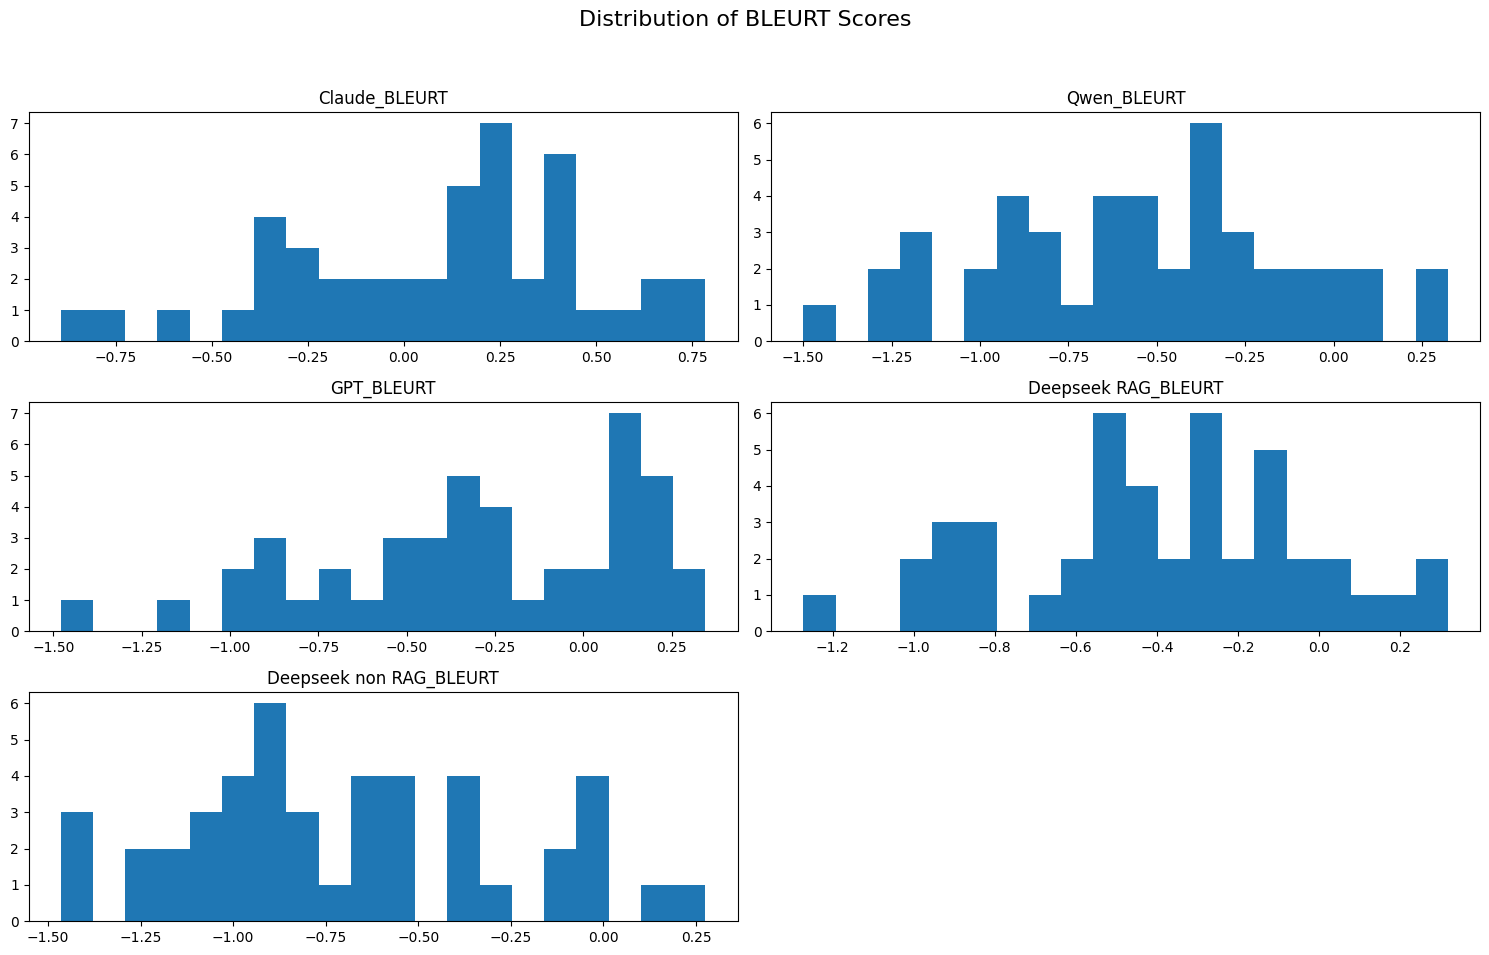

In [9]:
# Distribution of BLEURT 
import matplotlib.pyplot as plt

bleurt_columns = [col for col in eval_df.columns if col.endswith('_BLEURT')]
eval_df[bleurt_columns].hist(bins=20, figsize=(15, 10), grid=False, layout=(-1, 2))

plt.suptitle('Distribution of BLEURT Scores', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

In [ ]:
eval_df.to_csv('bert_bleurt_eval.csv')

In [14]:
from scipy import stats

def count_p_val(data):
    stat, p = stats.shapiro(data)
    print(f"Shapiro-Wilk Statistic = {stat:.4f}")
    print(f"p-value = {p:.4f}")

data_rag = eval_df['Deepseek RAG_P']
data_non_rag = eval_df['Deepseek non RAG_P']
count_p_val(data_rag)
count_p_val(data_non_rag)

Shapiro-Wilk Statistic = 0.9732
p-value = 0.3770
Shapiro-Wilk Statistic = 0.9662
p-value = 0.2088


In [16]:
t_stat, p_two_tailed = stats.ttest_rel(data_rag, data_non_rag)
if t_stat > 0:
    p_one_tailed = p_two_tailed / 2
else:
    p_one_tailed = 1 - (p_two_tailed / 2)

print(f"t-statistic = {t_stat:.4f}")
print(f"One-tailed p-value = {p_one_tailed:.4f}")
print(f"Two-tailed p-value = {p_two_tailed:.4f}")

t-statistic = 2.7449
One-tailed p-value = 0.0044
Two-tailed p-value = 0.0087


In [ ]:
# ===================================TEST 2=================================
data_gpt = eval_df['GPT_P']
data_qwen = eval_df['Qwen_P']
count_p_val(data_gpt)
count_p_val(data_qwen)

Shapiro-Wilk Statistic = 0.9800
p-value = 0.6182
Shapiro-Wilk Statistic = 0.9625
p-value = 0.1517


In [ ]:
# !pip install pingouin

  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ------- -------------------------------- 1.8/9.6 MB 9.1 MB/s eta 0:00:01
   --------------- ------------------------ 3.7/9.6 MB 9.1 MB/s eta 0:00:01
   -------------------- ------------------- 5.0/9.6 MB 8.4 MB/s eta 0:00:01
   -------------------------- ------------- 6.3/9.6 MB 7.6 MB/s eta 0:00:01
   ------------------------------- -------- 7.6/9.6 MB 7.3 MB/s eta 0:00:01
   ---------------------------------------  9.4/9.6 MB 7.6 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 7.5 MB/s  0:00:01
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 7.9 MB/s  0:00:00

   ---------------------------------------- 0/6 [tabulate]
   ------ --------------------------------- 1/6 [patsy]
   ------ -----------------

In [21]:
import pingouin as pg
anova_df = pd.DataFrame({
    'GPT': data_gpt,
    'Deepseek': data_rag,
    'Qwen': data_qwen
}).melt(var_name='model', value_name='score')

# Each observation corresponds to same test item
anova_df['subject'] = np.tile(np.arange(len(data_gpt)), 3)

anova = pg.rm_anova(dv='score', within='model', subject='subject', data=anova_df, detailed=True)
print(anova)

  Source        SS  DF        MS         F    p-unc       ng2       eps
0  model  0.001836   2  0.000918  1.312396  0.27439  0.009024  0.932064
1  Error  0.061553  88  0.000699       NaN      NaN       NaN       NaN


d:\Research_Assistant\evaluation_radiology_gpt\test-env\Lib\site-packages\pingouin\distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


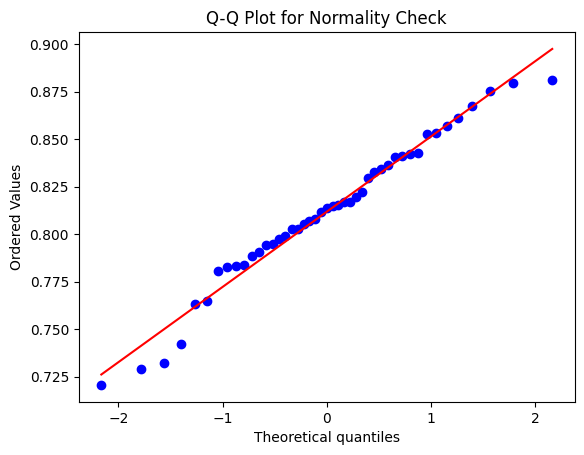

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats

stats.probplot(data_rag, dist="norm", plot=plt)
plt.title("Q-Q Plot for Normality Check")
plt.show()
